In [1]:
import numpy as np
import scipy.sparse as sp
from mpl_toolkits import mplot3d
from rom_am import ROM, EDMD
import matplotlib.pyplot as plt
import scipy.interpolate as si


$$
\begin{pmatrix}
\dot{u}(t)  \\
\dot{v}(t)  \\
\end{pmatrix} = \begin{pmatrix}
{v}(t)  \\
{v}(t)  \\
\end{pmatrix} + \begin{pmatrix}
0 \\
p(t) \\
\end{pmatrix}$$

We will then obtain the solution (and snapshots) of $\pmb{X}$ through numerical integration using `scipy.integrate.solve_ivp` (MATLAB's `ode45`-like)

In [14]:
mass = 1000
rigid = 1e7
Ls0 = 1.2
mu_coeff = 6
mu = mu_coeff * rigid / 0.2
A = 1
pres_init0 = 1e5
Ls0 = 1.2
L0 = 1
p = lambda t : np.sin(2 * np.pi / 3.6e-3 * t)

a_ = rigid;
b_ = mu;
c_ = A * pres_init0;
interm = (((np.sqrt((27 * b_ * c_**2 + 4 * a_**3) / b_)) / (b_ * 2 * 3**(3. / 2.))) - c_ / (2 * b_))**(1. / 3.);
u0 = interm - a_ / (3 * b_ * interm);

a = -rigid/mass - 3*mu*(u0**2)/mass
b = 3*mu*u0/mass
c = -mu/mass
d = lambda t : (u0**3)*mu/mass + rigid * u0/mass + A * p(t) / mass 
v_dot = lambda u, t : c * u**3 + b * u**2 + a * u + d(t)

ntt = 1000
train_t = np.linspace(0, 0.3, ntt)

from scipy.integrate import solve_ivp
def f(t, y): return np.array([y[1], v_dot(y[0], t)])
sol = solve_ivp(f, [0, 0.3], np.array([0.2, 0]), t_eval = train_t)

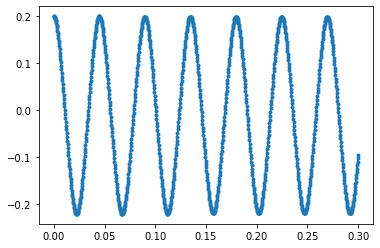

In [15]:
plt.plot(sol.t, sol.y[0, :], '.-');

In [43]:
X = sol.y[:1, :-1].reshape((1, -1))
Y = sol.y[:1, 1::].reshape((1, -1))

X = np.vstack((X, X**2, X**3, v_dot(X, train_t[:-1])))
Y = np.vstack((Y, Y**2, Y**3, v_dot(Y, train_t[1::])))

#observables = [lambda x : x, lambda x : x**2, lambda x : x**3,]

In [44]:
rank = 0
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = 0.00134529, rank =rank, observables=None, normalize=True)

In [45]:
pred = drom.predict(np.linspace(0, 0.3, 1000))

/Users/azzeddinetiba/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


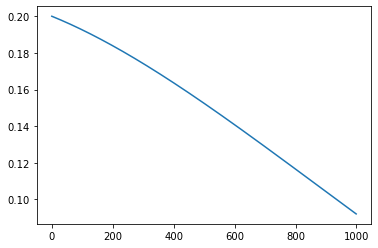

In [46]:
plt.plot(pred[0, :],);